In [2]:
## Install Dependencies

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [4]:
## construct the argument parser and parse the arguments

In [23]:
print(os.getcwd())
dataset_path=os.getcwd()+"//data"
model_path=os.getcwd()+"//model//drowsiness_model"
plot_path=os.getcwd()+"//plot"

c:\Users\PC\PycharmProjects\ComputerVision\DROWSINESS_tf


In [6]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [7]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
imagePaths = [imagePath.replace("\\","//",-1) for imagePath in imagePaths]
data = []
labels = []

[INFO] loading images...


In [8]:
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split("//")[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

In [11]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [12]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


In [13]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [14]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", 
                        include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

In [15]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [16]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [17]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [18]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


c:\Users\PC\Anaconda3\envs\tf-gpu2.5\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
# train the head of the network:::BS=32|^
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
3/3 [==============================] - 30s 3s/step - loss: 1.1117 - accuracy: 0.5109 - val_loss: 0.9548 - val_accuracy: 0.5000
Epoch 2/20
3/3 [==============================] - 3s 917ms/step - loss: 0.9120 - accuracy: 0.5652 - val_loss: 0.8339 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 3s 791ms/step - loss: 0.8458 - accuracy: 0.5217 - val_loss: 0.7813 - val_accuracy: 0.5000
Epoch 4/20
3/3 [==============================] - 3s 1s/step - loss: 0.8183 - accuracy: 0.5208 - val_loss: 0.7606 - val_accuracy: 0.3750
Epoch 5/20
3/3 [==============================] - 3s 784ms/step - loss: 0.8297 - accuracy: 0.4583 - val_loss: 0.7490 - val_accuracy: 0.3750
Epoch 6/20
3/3 [==============================] - 3s 757ms/step - loss: 0.8382 - accuracy: 0.4688 - val_loss: 0.7366 - val_accuracy: 0.4375
Epoch 7/20
3/3 [==============================] - 3s 751ms/step - loss: 0.8414 - accuracy: 0.4674 - val_loss: 0.7272 - val_accuracy: 0.5000
E

In [20]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
1/1 [==============================] - 7s 7s/step


In [21]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [24]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model... path: %s"%(model_path+".h5"))
model.save(model_path+".h5")

              precision    recall  f1-score   support

       awake       0.57      0.81      0.67        16
      drowsy       0.67      0.38      0.48        16

    accuracy                           0.59        32
   macro avg       0.62      0.59      0.57        32
weighted avg       0.62      0.59      0.57        32

[INFO] saving mask detector model... path: c:\Users\PC\PycharmProjects\ComputerVision\DROWSINESS_tf//model//drowsiness_model.h5


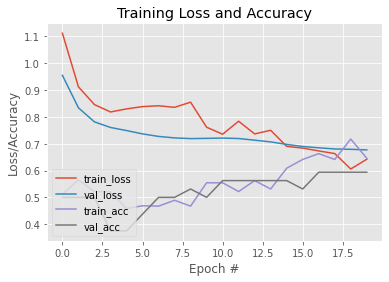

In [25]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(plot_path)